### Nsynth Experiments
#### Part 2 : Modeling Arithmetic
(This notebook is maintained as experiments towards Master thesis research by Manaswi Mishra at MTG, UPF.)

In [64]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### Environment Setup

In [65]:
# Install magenta
print('Installing Magenta...\n')
!pip install -q magenta


# NOTE : gsutil not working in python 3.6. Loading model checkpoint from local drive currently. Uncomment below when fixed.
'''
print('Installing gsutil...\n')
!pip install -q gsutil

print('Downloading Pretrained Models...\n')
# Copy checkpoints from google cloud
# Copying 1GB, takes a minute
print('Getting Instruments Model...\n')
!gsutil -q -m cp -R gs://download.magenta.tensorflow.org/models/nsynth/wavenet-ckpt.tar /content/
print('Getting Voices Model...\n')
!gsutil -q -m cp -R gs://download.magenta.tensorflow.org/models/nsynth/wavenet-voice-ckpt.tar.gz /content/
!cd /content/
!tar -xvf wavenet-ckpt.tar > /dev/null
!tar -xvf wavenet-voice-ckpt.tar.gz > /dev/null
'''


print('Importing Modules...\n')
# Load modules and helper functions
import os
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib inline

from magenta.models.nsynth import utils
from magenta.models.nsynth.wavenet import fastgen

get_name = lambda f: os.path.splitext(os.path.basename(f))[0]
output_path = './output/EncodingArithmetic/'

print('Sucess!! Environment is now setup.')

Installing Magenta...

Importing Modules...

Sucess!! Environment is now setup.


In [66]:
# Importing model checkpoints from local drive /model/

Model = "Instruments"
ckpt = {'Instruments':'./model/wavenet-ckpt/model.ckpt-200000',
       'Voices':'./model/wavenet-voice-ckpt/model.ckpt-200000'}

ckpt_path = ckpt[Model]
print('Using model pretrained on %s.' % Model)

Using model pretrained on Instruments.


### Loading Audio
Choose 2 audio file (only upto 2 seconds is selected, because of the expensive computation of synthesizing from encoding)
> About 4 minutes per second of audio batch to synthesize on a GPU

In [67]:
audio_file = ['./sounds/354233__mtg__double-bass-c2.wav','./sounds/354534__mtg__flute-b5_short.wav']
name_list = [get_name(audio_file[i]) for i in range(len(audio_file))]
audio_list = []

Length = 2.0
SR = 16000
SAMPLE_LENGTH = int(Length * SR)

for i in range(len(audio_file)):
    audio = utils.load_audio(audio_file[i], sample_length = SAMPLE_LENGTH, sr = SR)
    audio_list.append(audio)

for i in range(len(audio_list)):
    audio_list[i] = audio_list[i] / np.abs(audio_list[i]).max()

    if len(audio_list[i]) < SAMPLE_LENGTH:
        padding = SAMPLE_LENGTH - len(audio_list[i])
        audio_list[i] = np.pad(audio_list[i], (0, padding), 'constant')

print('Here is ' + name_list[0])
ipd.Audio(audio_list[0], rate = SR)

Here is 354233__mtg__double-bass-c2


In [68]:
print('Here is ' + name_list[1])
ipd.Audio(audio_list[1], rate = SR)

Here is 354534__mtg__flute-b5_short


### Generate Encodings

In [69]:
audio = np.array(audio_list)
z = fastgen.encode(audio, ckpt_path, SAMPLE_LENGTH)
print('Encoded %d files' % z.shape[0])

INFO:tensorflow:Restoring parameters from ./model/wavenet-ckpt/model.ckpt-200000
Encoded 2 files


Text(0.5,1,'NSynth Encoding')

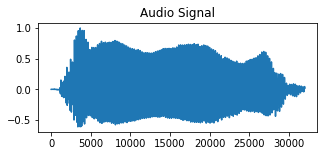

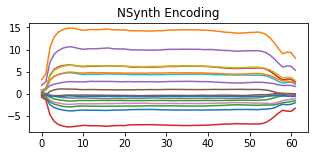

In [70]:
plt.figure(figsize=(5, 2))
plt.plot(audio[0])
plt.title('Audio Signal')

plt.figure(figsize=(5, 2))
plt.plot(z[0])
plt.title('NSynth Encoding')

Text(0.5,1,'NSynth Encoding')

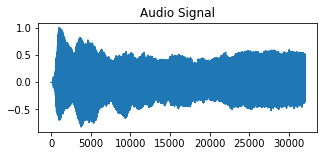

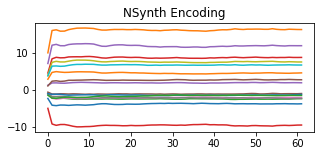

In [71]:
plt.figure(figsize=(5, 2))
plt.plot(audio[1])
plt.title('Audio Signal')

plt.figure(figsize=(5, 2))
plt.plot(z[1])
plt.title('NSynth Encoding')

In [72]:
z_list = [z_ for z_ in z]
encodings = np.array(z_list)
save_paths = [output_path + name + '.wav' for name in name_list]
encoding_path_list = save_paths

In [73]:
encoding_list = [encodings_i for encodings_i in encodings]
encoding_name_list = [get_name(fname) + '.wav' for fname in encoding_path_list]

## Creating Interpolations and extrapolations

In [74]:
interp_factor = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5]
for i in range(len(interp_factor)):
    z_i = (encoding_list[0] * interp_factor[i]) + (encoding_list[1] * (1-interp_factor[i]))
    
    encoding_list.append(z_i)
    encoding_name_list.append('bass_' + str(interp_factor[i]) + 'flute' + '.wav')

> Its **Synthesis time**. Put on your patience hat. (4 minutes per each second of batch audio on my NVIDIA GTX 1060 GPU)

In [79]:
encoding_path_list = [os.path.join(output_path,encode_i) for encode_i in encoding_name_list]
e = np.array(encoding_list)


fastgen.synthesize(e,
                   save_paths=encoding_path_list,
                   checkpoint_path=ckpt_path,
                   samples_per_save=int(SAMPLE_LENGTH / 10))

INFO:tensorflow:Restoring parameters from ./model/wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Sample: 0
INFO:tensorflow:Saving: ./output/EncodingArithmetic/354233__mtg__double-bass-c2.wav
INFO:tensorflow:Saving: ./output/EncodingArithmetic/354534__mtg__flute-b5_short.wav
INFO:tensorflow:Saving: ./output/EncodingArithmetic/bass_0flute.wav
INFO:tensorflow:Saving: ./output/EncodingArithmetic/bass_0.25flute.wav
INFO:tensorflow:Saving: ./output/EncodingArithmetic/bass_0.5flute.wav
INFO:tensorflow:Saving: ./output/EncodingArithmetic/bass_0.75flute.wav
INFO:tensorflow:Saving: ./output/EncodingArithmetic/bass_1flute.wav
INFO:tensorflow:Saving: ./output/EncodingArithmetic/bass_1.25flute.wav
INFO:tensorflow:Saving: ./output/EncodingArithmetic/bass_1.5flute.wav
INFO:tensorflow:Sample: 100
INFO:tensorflow:Sample: 200
INFO:tensorflow:Sample: 300
INFO:tensorflow:Sample: 400
INFO:tensorflow:Sample: 500
INFO:tensorflow:Sample: 600
INFO:tensorflow:Sample: 700
INFO:tensorflow:Sample: 800
INFO:tensorf

INFO:tensorflow:Saving: ./output/EncodingArithmetic/bass_0flute.wav
INFO:tensorflow:Saving: ./output/EncodingArithmetic/bass_0.25flute.wav
INFO:tensorflow:Saving: ./output/EncodingArithmetic/bass_0.5flute.wav
INFO:tensorflow:Saving: ./output/EncodingArithmetic/bass_0.75flute.wav
INFO:tensorflow:Saving: ./output/EncodingArithmetic/bass_1flute.wav
INFO:tensorflow:Saving: ./output/EncodingArithmetic/bass_1.25flute.wav
INFO:tensorflow:Saving: ./output/EncodingArithmetic/bass_1.5flute.wav
INFO:tensorflow:Sample: 16100
INFO:tensorflow:Sample: 16200
INFO:tensorflow:Sample: 16300
INFO:tensorflow:Sample: 16400
INFO:tensorflow:Sample: 16500
INFO:tensorflow:Sample: 16600
INFO:tensorflow:Sample: 16700
INFO:tensorflow:Sample: 16800
INFO:tensorflow:Sample: 16900
INFO:tensorflow:Sample: 17000
INFO:tensorflow:Sample: 17100
INFO:tensorflow:Sample: 17200
INFO:tensorflow:Sample: 17300
INFO:tensorflow:Sample: 17400
INFO:tensorflow:Sample: 17500
INFO:tensorflow:Sample: 17600
INFO:tensorflow:Sample: 17700
I

INFO:tensorflow:Saving: ./output/EncodingArithmetic/bass_0.75flute.wav
INFO:tensorflow:Saving: ./output/EncodingArithmetic/bass_1flute.wav
INFO:tensorflow:Saving: ./output/EncodingArithmetic/bass_1.25flute.wav
INFO:tensorflow:Saving: ./output/EncodingArithmetic/bass_1.5flute.wav


## Loading Audio for Source Filter Arithmetic

In [80]:
audio_file = ['./sounds/354233__mtg__double-bass-c2.wav',
              './sounds/Sounds_FX/G61-40100-1111-20593_nofx.wav',
              './sounds/Sounds_FX/G61-40100-3341-33697_tremolo.wav',
              './sounds/Sounds_FX/G61-40100-3351-35569_vibrato.wav',
              './sounds/Sounds_FX/G61-40100-3321-29953_flanger.wav' ]

name_list = [get_name(audio_file[i]) for i in range(len(audio_file))]
audio_list = []

Length = 2.0
SR = 16000
SAMPLE_LENGTH = int(Length * SR)

for i in range(len(audio_file)):
    audio = utils.load_audio(audio_file[i], sample_length = SAMPLE_LENGTH, sr = SR)
    audio_list.append(audio)

for i in range(len(audio_list)):
    audio_list[i] = audio_list[i] / np.abs(audio_list[i]).max()

    if len(audio_list[i]) < SAMPLE_LENGTH:
        padding = SAMPLE_LENGTH - len(audio_list[i])
        audio_list[i] = np.pad(audio_list[i], (0, padding), 'constant')

In [81]:
audio = np.array(audio_list)
z = fastgen.encode(audio, ckpt_path, SAMPLE_LENGTH)
print('Encoded %d files' % z.shape[0])

INFO:tensorflow:Restoring parameters from ./model/wavenet-ckpt/model.ckpt-200000
Encoded 5 files


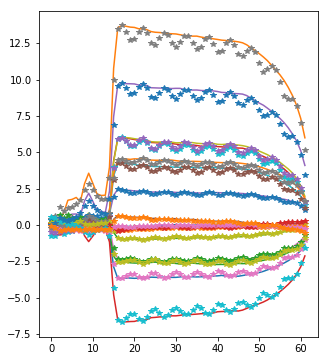

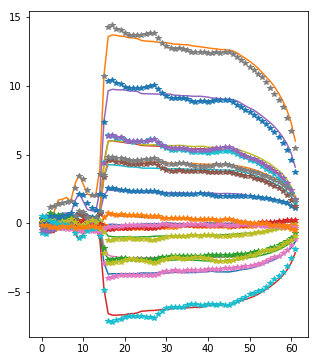

In [109]:
plt.figure(figsize=(5, 6))
plt.plot(z[1]);
plt.plot(z[2],'*');

plt.figure(figsize=(5, 6))
plt.plot(z[1]);
plt.plot(z[4],'*');

As you can see in these overlapping plots, the embeddings show the influence of the effects on the source without any effects/filter.

Text(0.5,1,'flanger effect')

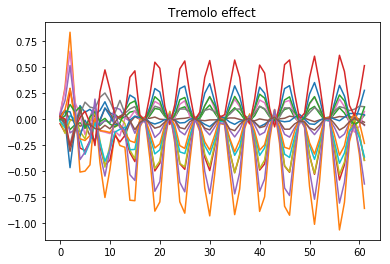

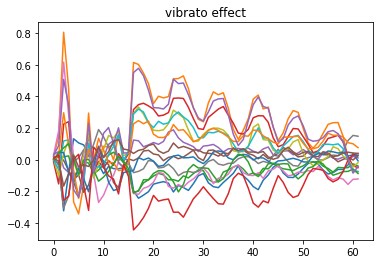

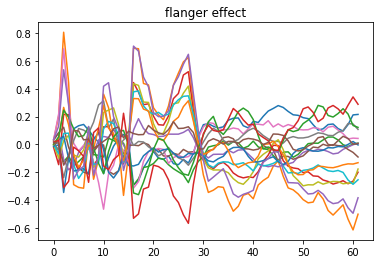

In [114]:
z_tremolo= z[2] - z[1]
plt.plot(z_tremolo);
plt.title("Tremolo effect")

z_vibrato = z[3] - z[1]
plt.figure();
plt.plot(z_vibrato);
plt.title("vibrato effect")

z_flanger = z[4] - z[1]
plt.figure();
plt.plot(z_flanger);
plt.title("flanger effect")

Adding the Effect to a different sound.

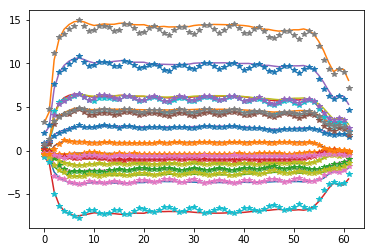

In [115]:
z_new_tremolo = z[0] + z_tremolo
z_new_vibrato = z[0] + z_vibrato
z_new_flanger = z[0] + z_flanger
plt.plot(z[0]);
plt.plot(z_new_tremolo,'*');

In [116]:
z_list = [z[0],z[1],z[2],z_new_tremolo, z_new_vibrato, z_new_flanger]
name_list = [get_name(audio_file[0]), get_name(audio_file[1]), get_name(audio_file[2]), 
             get_name(audio_file[0]) + '_With_tremolo',
             get_name(audio_file[0]) + '_With_vibrato',
             get_name(audio_file[0]) + '_With_flanger']
encodings = np.array(z_list)
save_paths = [output_path + name + '.wav' for name in name_list]
encoding_path_list = save_paths

In [117]:
print(encoding_path_list)

['./output/EncodingArithmetic/354233__mtg__double-bass-c2.wav', './output/EncodingArithmetic/G61-40100-1111-20593_nofx.wav', './output/EncodingArithmetic/G61-40100-3341-33697_tremolo.wav', './output/EncodingArithmetic/354233__mtg__double-bass-c2_With_tremolo.wav', './output/EncodingArithmetic/354233__mtg__double-bass-c2_With_vibrato.wav', './output/EncodingArithmetic/354233__mtg__double-bass-c2_With_flanger.wav']


In [108]:
encoding_list = [encodings_i for encodings_i in encodings]
e = np.array(encoding_list)
fastgen.synthesize(e,
                   save_paths=encoding_path_list,
                   checkpoint_path=ckpt_path,
                   samples_per_save=int(SAMPLE_LENGTH / 10))

INFO:tensorflow:Restoring parameters from ./model/wavenet-ckpt/model.ckpt-200000
INFO:tensorflow:Sample: 0
INFO:tensorflow:Saving: ./output/EncodingArithmetic/354233__mtg__double-bass-c2.wav
INFO:tensorflow:Saving: ./output/EncodingArithmetic/G61-40100-1111-20593_nofx.wav
INFO:tensorflow:Saving: ./output/EncodingArithmetic/G61-40100-3341-33697_tremolo.wav
INFO:tensorflow:Saving: ./output/EncodingArithmetic/354233__mtg__double-bass-c2_With_tremolo.wav
INFO:tensorflow:Sample: 100
INFO:tensorflow:Sample: 200
INFO:tensorflow:Sample: 300
INFO:tensorflow:Sample: 400
INFO:tensorflow:Sample: 500
INFO:tensorflow:Sample: 600
INFO:tensorflow:Sample: 700
INFO:tensorflow:Sample: 800
INFO:tensorflow:Sample: 900
INFO:tensorflow:Sample: 1000
INFO:tensorflow:Sample: 1100
INFO:tensorflow:Sample: 1200
INFO:tensorflow:Sample: 1300
INFO:tensorflow:Sample: 1400
INFO:tensorflow:Sample: 1500
INFO:tensorflow:Sample: 1600
INFO:tensorflow:Sample: 1700
INFO:tensorflow:Sample: 1800
INFO:tensorflow:Sample: 1900
INF

INFO:tensorflow:Sample: 19300
INFO:tensorflow:Sample: 19400
INFO:tensorflow:Sample: 19500
INFO:tensorflow:Sample: 19600
INFO:tensorflow:Sample: 19700
INFO:tensorflow:Sample: 19800
INFO:tensorflow:Sample: 19900
INFO:tensorflow:Sample: 20000
INFO:tensorflow:Sample: 20100
INFO:tensorflow:Sample: 20200
INFO:tensorflow:Sample: 20300
INFO:tensorflow:Sample: 20400
INFO:tensorflow:Sample: 20500
INFO:tensorflow:Sample: 20600
INFO:tensorflow:Sample: 20700
INFO:tensorflow:Sample: 20800
INFO:tensorflow:Sample: 20900
INFO:tensorflow:Sample: 21000
INFO:tensorflow:Sample: 21100
INFO:tensorflow:Sample: 21200
INFO:tensorflow:Sample: 21300
INFO:tensorflow:Sample: 21400
INFO:tensorflow:Sample: 21500
INFO:tensorflow:Sample: 21600
INFO:tensorflow:Sample: 21700
INFO:tensorflow:Sample: 21800
INFO:tensorflow:Sample: 21900
INFO:tensorflow:Sample: 22000
INFO:tensorflow:Sample: 22100
INFO:tensorflow:Sample: 22200
INFO:tensorflow:Sample: 22300
INFO:tensorflow:Sample: 22400
INFO:tensorflow:Saving: ./output/Encodin